# **Imports**


In [9]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [10]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


# **Data Load**


In [11]:
# Initialize the data loader for a train dataset
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# # Initialize the data loader for a val dataset
# val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
# val_dataset = val_loader.load_unlabeled_data()

In [12]:
import os
import shutil
import numpy as np


def is_grayscale(image_tensor):
    """
    Check if an image tensor is grayscale. Assumes input is a 3-channel image.

    Parameters
    ----------
    image_tensor : torch.Tensor
        The image tensor of shape (C, H, W).

    Returns
    -------
    bool
        True if the image is grayscale, False otherwise.
    """
    # Convert tensor to numpy for easy channel comparison
    image_np = image_tensor.numpy()

    # Check if all channels (R, G, B) are the same
    return np.all(image_np[0] == image_np[1]) and np.all(image_np[0] == image_np[2])


def copy_grayscale_images(dataset, dataset_name, target_folder):
    """
    Identifies grayscale images in the dataset and copies them to a separate folder, preserving class structure.

    Parameters
    ----------
    dataset : torchvision.datasets.ImageFolder
        The dataset (train, test, or val) to process.
    dataset_name : str
        Name of the dataset ('test' or 'train') to use for logging.
    target_folder : str
        Path to the folder where grayscale images will be copied.
    """
    # Create main grayscale directory if it doesn't exist
    grayscale_dir = os.path.join(target_folder, "grayscale_images")
    if not os.path.exists(grayscale_dir):
        os.makedirs(grayscale_dir)

    # Iterate over the dataset
    for i, (image_tensor, label) in enumerate(dataset):
        if is_grayscale(image_tensor):
            # Get the original image path and class label
            image_path = dataset.imgs[i][0]
            class_name = dataset.classes[label]

            # Create class subfolder if it doesn't exist
            class_dir = os.path.join(grayscale_dir, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)

            # Copy image to the grayscale folder, preserving the class structure
            image_name = f"{dataset_name}_{os.path.basename(image_path)}"
            new_image_path = os.path.join(class_dir, image_name)
            shutil.copy(image_path, new_image_path)
            print(f"Copied {image_name} to {class_dir}")


grayscale_output_path = "./db"

# Copy grayscale images from test and train datasets
copy_grayscale_images(test_dataset, "test", grayscale_output_path)
copy_grayscale_images(train_dataset, "train", grayscale_output_path)

Copied test_20246.jpg to ./db\grayscale_images\buildings
Copied test_20430.jpg to ./db\grayscale_images\buildings
Copied test_20846.jpg to ./db\grayscale_images\buildings
Copied test_20858.jpg to ./db\grayscale_images\buildings
Copied test_20966.jpg to ./db\grayscale_images\buildings
Copied test_21182.jpg to ./db\grayscale_images\buildings
Copied test_21339.jpg to ./db\grayscale_images\buildings
Copied test_21648.jpg to ./db\grayscale_images\buildings
Copied test_21772.jpg to ./db\grayscale_images\buildings
Copied test_22025.jpg to ./db\grayscale_images\buildings
Copied test_22134.jpg to ./db\grayscale_images\buildings
Copied test_22317.jpg to ./db\grayscale_images\buildings
Copied test_22447.jpg to ./db\grayscale_images\buildings
Copied test_22531.jpg to ./db\grayscale_images\buildings
Copied test_22586.jpg to ./db\grayscale_images\buildings
Copied test_22702.jpg to ./db\grayscale_images\buildings
Copied test_22899.jpg to ./db\grayscale_images\buildings
Copied test_22911.jpg to ./db\g

In [13]:
# Initialize the data loader for a test dataset
grayscale_loader = DataLoader(dataset_type="test", path="./db/grayscale_images")
grayscale_dataset = grayscale_loader.load_data()
print(f"Grayscale dataset type: {type(grayscale_dataset)}")

Grayscale dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [14]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
# print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


# **EDA**


In [15]:
eda = EDA(train_dataset, train_dataset.classes)

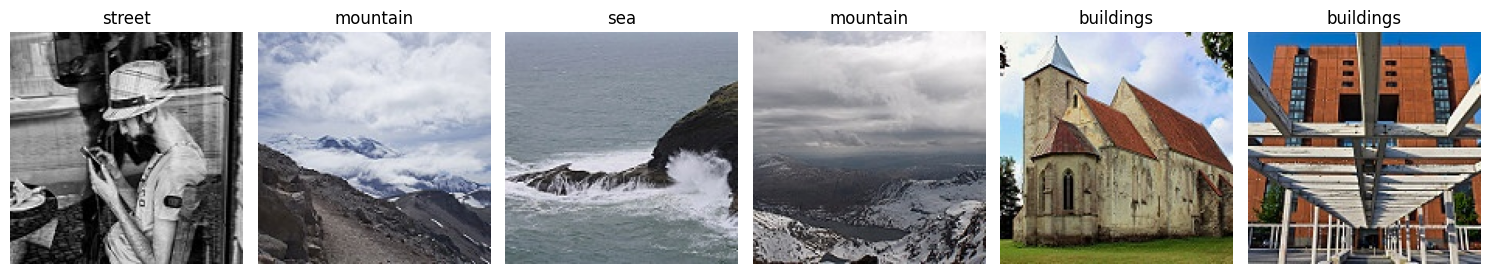

In [16]:
eda.show_sample_images(num_images=6)

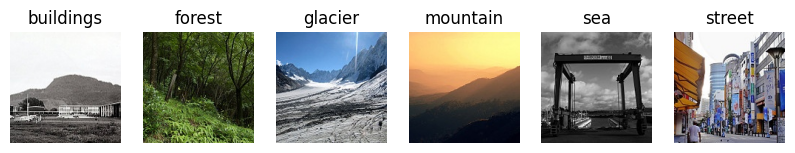

In [17]:
eda.show_images_from_each_class()

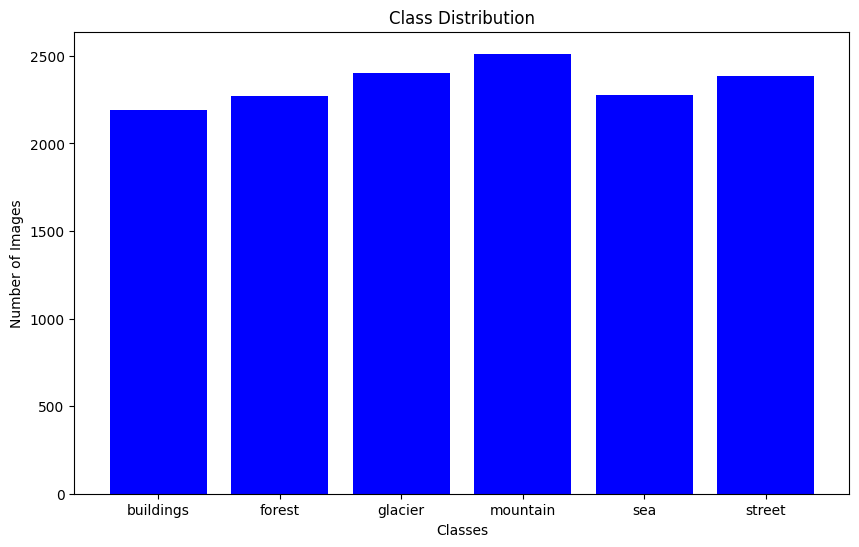

In [18]:
eda.plot_class_distribution()

In [19]:
eda.show_image_shape()

Shape of an image: torch.Size([3, 150, 150])


# **Preprocessing**


In [20]:
preprocessor = CNNPreprocessor()

In [21]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                                  | Parameters                                                         |
+======================+==============================================================================+====================================================================+
| ToGray               | Converts the image to grayscale.                                             | None: No parameters. Converts to grayscale using luminance.        |
+----------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given

In [22]:
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        # "VerticalFlip": {"enabled": True, "p": 0.5},
        # "ColorJitter": {
        #     "enabled": True,
        #     "brightness": 0.5,
        #     "contrast": 0.5,
        #     "saturation": 0.5,
        #     "hue": 0.2,
        # },
        # "GaussianBlur": {"enabled": True, "kernel_size": (5, 9), "sigma": (0.1, 5)},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    # val_transform_settings={
    #     "Normalize": {
    #         "enabled": True,
    #         "mean": [0.485, 0.456, 0.406],
    #         "std": [0.229, 0.224, 0.225],
    #     },
    # },
)

In [23]:
g_preprocessor = CNNPreprocessor()
g_preprocessor.set_transform_settings(
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
)
transformed_grayscale_dataset = g_preprocessor.transform_dataset(
    grayscale_dataset, dataset_type="test"
)

In [24]:
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
# img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [25]:
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [26]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [27]:
# transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [28]:
# print(f"Val dataset type: {type(transformed_val_dataset)}")

In [29]:
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
# img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [30]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [31]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [32]:
param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [10],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["AvgPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [1],
}

In [33]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [34]:
model_trainer = CNNTrainer(device="cuda")

In [35]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [36]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda


Total Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}
Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}

Epoch 1/10


Total Training Progress:  10%|█         | 1/10 [01:43<15:33, 103.73s/it]

Training Loss: 1.1831192245244437, Training Accuracy: 0.5322787516032492
Validation Loss: 0.9341911021620035, Validation Accuracy: 0.6596666666666666

Epoch 2/10


Total Training Progress:  20%|██        | 2/10 [03:33<14:20, 107.57s/it]

Training Loss: 0.9197003891975841, Training Accuracy: 0.6509904517600114
Validation Loss: 0.6272982297207605, Validation Accuracy: 0.7766666666666666

Epoch 3/10


Total Training Progress:  30%|███       | 3/10 [05:00<11:26, 98.12s/it] 

Training Loss: 0.799760335975736, Training Accuracy: 0.7073535699016674
Validation Loss: 0.6169924659931914, Validation Accuracy: 0.7833333333333333

Epoch 4/10


Total Training Progress:  40%|████      | 4/10 [06:27<09:21, 93.61s/it]

Training Loss: 0.7331935472803398, Training Accuracy: 0.7288727376371669
Validation Loss: 0.5455426144354204, Validation Accuracy: 0.8056666666666666

Epoch 5/10


Total Training Progress:  50%|█████     | 5/10 [07:54<07:36, 91.24s/it]

Training Loss: 0.702500035065589, Training Accuracy: 0.7394185549380077
Validation Loss: 0.5293062110926877, Validation Accuracy: 0.8143333333333334

Epoch 6/10


Total Training Progress:  60%|██████    | 6/10 [09:22<05:59, 89.99s/it]

Training Loss: 0.6549980768155315, Training Accuracy: 0.7568049023799345
Validation Loss: 0.5054297179697042, Validation Accuracy: 0.8293333333333334

Epoch 7/10


Total Training Progress:  70%|███████   | 7/10 [12:34<06:10, 123.34s/it]

Training Loss: 0.6364982205194873, Training Accuracy: 0.7659968647570187
Validation Loss: 0.5314701964157297, Validation Accuracy: 0.8073333333333333

Epoch 8/10


Total Training Progress:  80%|████████  | 8/10 [14:08<03:48, 114.10s/it]

Training Loss: 0.6237749659831812, Training Accuracy: 0.7759726378794357
Validation Loss: 0.46085502847315785, Validation Accuracy: 0.8353333333333334

Epoch 9/10


Total Training Progress:  90%|█████████ | 9/10 [15:54<01:51, 111.51s/it]

Training Loss: 0.6058198594507297, Training Accuracy: 0.7768277041470714
Validation Loss: 0.45854523284063536, Validation Accuracy: 0.8463333333333334

Epoch 10/10


Total Training Progress: 100%|██████████| 10/10 [17:21<00:00, 104.09s/it]

Training Loss: 0.5927510199249469, Training Accuracy: 0.7835257232435514


Total Training Progress: 100%|██████████| 10/10 [17:30<00:00, 105.07s/it]

Validation Loss: 0.407826881903407, Validation Accuracy: 0.8536666666666667
Validation Accuracy for cnn_model: 0.7835257232435514

Best Model: cnn_model with score: 0.7835257232435514


In [37]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [38]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x000001BDA36F08F0>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}}
{'cnn_model': 0.7835257232435514}
cnn_model


# **Model Evaluator**


In [39]:
evaluator = CNNEvaluator()

In [40]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─AvgPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─AvgPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─AvgPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           27,558,144
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 27,685,062
Trainable params: 27,685,062
Non-trainable params: 0


In [41]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.407826881903407, Validation Accuracy: 0.8536666666666667
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.853667,0.855475,0.853723,0.857621,0.853667



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.783526



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


In [42]:
evaluator.display_results(
    test_dataset=transformed_grayscale_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.40344712665925425, Validation Accuracy: 0.8711819389110226
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.871182,0.770944,0.875367,0.883198,0.871182



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.783526



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


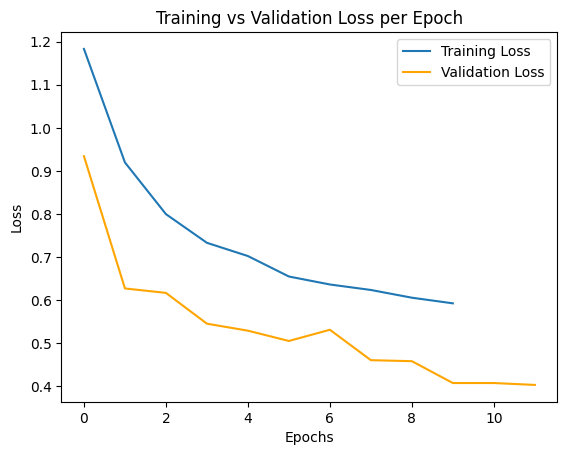

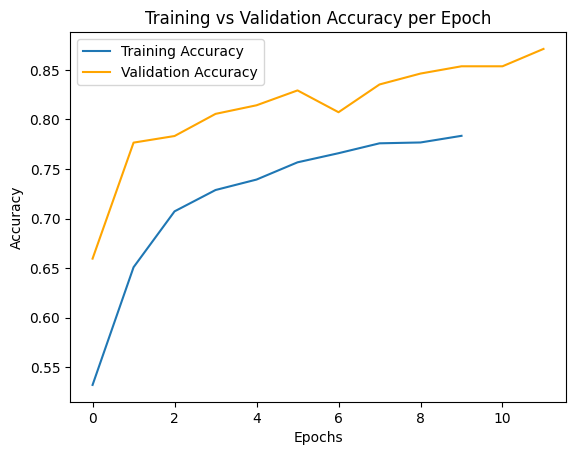

In [43]:
evaluator.plot_loss_history(best_models, best_model_name)
evaluator.plot_accuracy_history(best_models, best_model_name)

In [44]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions:**

# **High Model Accuracy:**

**Validation Accuracy:** The model achieved a validation accuracy of 88.5%. This suggests that the model generalizes well to unseen data, predicting the correct outcomes in most cases during validation.

**Evaluation on Test Set:** The model achieved an accuracy of 0.885 on the test set. Furthermore, additional evaluation metrics such as:

**Balanced Accuracy:** 0.8860

**F1 Score:** 0.8840

**Precision:** 0.8882

**Recall:** 0.8850

These metrics indicate that the model performs consistently well across various evaluation aspects, demonstrating a strong balance between precision and recall.

# **Optimal Hyperparameters:**

**Best Architecture:** The optimal architecture consisted of 3 convolutional layers with the following configuration: [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]. This design proved to be effective for feature extraction and subsequent classification tasks.

**Hyperparameter Tuning: The best model was obtained with:**

**Batch size:** 16
**Learning rate:** 0.001
**ReLU activation function**
**Adam optimizer**

The inclusion of a dropout rate of 0.1 helped to prevent overfitting during training. The model used AvgPooling (kernel size = 2, stride = 2, padding = 1) to reduce the spatial dimensions while preserving the most important features.

# **Regularization and Loss Function:**

**Regularization:** The use of dropout after each hidden layer (with a dropout rate of 0.1) proved effective in mitigating overfitting, acting as a regularization method by randomly dropping units during training. This added stochasticity helps to improve the model's generalization ability.

**Optimizer and Loss Function:** The Adam optimizer, combined with cross-entropy loss, was instrumental in effectively optimizing the model. This combination provided a balance between fast convergence and stable gradient updates.

# **Cross-Validation Score:**

The cross-validation score for the best model was 0.843, indicating strong generalization across different data splits. While the model performed well during both cross-validation and on the test set, there remains a small gap between training and validation scores, suggesting that further fine-tuning or additional regularization techniques could still offer marginal improvements.
